In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.stats import linregress
import os
from pathlib import Path
import re
import finufft

# Function to read .okc database files from Visit
def extract_fields_from_okc(file_path, fields):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Read header to get number of fields and points
    header = lines[0].strip()
    n_fields, n_points, foo = map(int, header.split())
    # Read field names in the next n_fields lines
    field_names = [line.strip() for line in lines[1:(n_fields + 1)]]

    # Data starts at line 2 * n_fields + 1
    start_data_lines = (2 * n_fields + 1)

    df = pd.read_csv(file_path, sep=r'\s+', skiprows=start_data_lines, names=field_names)
    sliced_df = df[fields]
    return sliced_df

def cartesian_df_to_polar(dataframe):
    df = dataframe
    r = np.sqrt(df['x'].to_numpy() ** 2 + df['y'].to_numpy() ** 2)
    theta = np.arctan2(df['y'].to_numpy(), df['x'].to_numpy())
    r_mean = np.mean(r)
    r_fluct = r - r_mean
    return theta, r_mean, r_fluct

# Function to calculate FFT after interpolation using point to point interpolation
# Using os_fact, data can over oversampled
def interpolated_spline_FFT(x, f, os_fact=1, n_modes=50):
    # Define uniform x range 
    x_uniform = np.linspace(x[0], x[-1], int(os_fact*len(x)), endpoint=True)

    # Interpolate r to uniform x
    spline = interp1d(x, f, kind='cubic')
    f_uniform = spline(x_uniform)
    dx = (x_uniform[1] - x_uniform[0])

    # Perform the Fourier Transform
    fft_coeffs = np.fft.fft(f_uniform)
    spect_wave_nums = np.fft.fftfreq(len(f_uniform), dx)

    # Convert to one-sided over angular frequency and normalize by spacing dx
    pos_ind = len(spect_wave_nums) // 2
    if n_modes < 0:
        wave_nums = 2 * np.pi * spect_wave_nums[:pos_ind]   
        amplitudes = 2 * np.abs(fft_coeffs)[:pos_ind] / len(x_uniform)
    else:
        if n_modes > pos_ind: print("[WARNING] requested number of modes is higher than possible")
        wave_nums = 2 * np.pi * spect_wave_nums[:n_modes]
        amplitudes = np.abs(fft_coeffs)[:n_modes] / len(x_uniform)
    return wave_nums, amplitudes

# Function to calculate FFT after interpolation using an univariate spline, smooting = 0 is equal to the interp1d function
def interpolated_smooth_FFT(x, f, n_grid=-1, n_modes=-1, smoothing=0):
    # Define unifrom grid with n_grid gridpoints
    if n_grid < 0: n_grid = len(x)
    x_uniform = np.linspace(x[0], x[-1], n_grid, endpoint=False)

    # Interpolate f to x_uniform
    spline = UnivariateSpline(x, f, s=smoothing)
    f_uniform = spline(x_uniform)
    dx = x_uniform[1] - x_uniform[0]

    # Perform the Fourier Transform
    fft_coeffs = np.fft.fft(f_uniform)
    spect_wave_nums = np.fft.fftfreq(len(f_uniform), d=dx)
    
    # Convert to one-sided over angular wavenumber and normalize the amplitude
    pos_ind = len(spect_wave_nums) // 2
    if n_modes < 0:
        wave_nums = 2 * np.pi * spect_wave_nums[:pos_ind]   
        amplitudes = np.abs(fft_coeffs)[:pos_ind] * dx
    else:
        if n_modes > pos_ind: print("[WARNING] requested number of modes is higher than possible")
        wave_nums = 2 * np.pi * spect_wave_nums[:n_modes]
        amplitudes = np.abs(fft_coeffs)[:n_modes] * dx

    return wave_nums, amplitudes

def interpolated_NUFFT(x_norm, f, modes, r_mean, n_grid=-1):
    # Define unifrom grid with n_grid gridpoints
    x = x_norm + np.pi
    if n_grid < 0: n_grid = len(x)
    x_uniform = np.linspace(x[0], x[-1], n_grid, endpoint=True)

    # Interpolate f to x_uniform
    spline = interp1d(x, f, kind='cubic')
    f_uniform = spline(x_uniform)
    dx = x_uniform[1] - x_uniform[0]

    wave_nums_norm = np.asarray(modes, dtype=np.float64)
    wave_nums = wave_nums_norm / r_mean  
    f_uniform = np.asarray(f_uniform, dtype=np.complex128)
    coeffs = finufft.nufft1d3(x_uniform, f_uniform, wave_nums_norm)
    amplitudes = np.abs(coeffs) * dx
    return wave_nums, amplitudes

def least_squares_fit(x_norm, f, n_modes=10, modes=None, r_mean=1.0):
    # Manual mode switch
    if modes is None: wave_nums_norm = np.arange(n_modes)
    else: wave_nums_norm = modes

    wave_nums = wave_nums_norm / r_mean  

    # Design matrix for complex exponentials
    A = np.exp(1j * np.outer(x_norm, wave_nums_norm))  # shape (N, kmax)
    
    # Solve least squares for Fourier coefficients
    coeffs, *_ = np.linalg.lstsq(A, f, rcond=None)
    amplitudes = np.abs(coeffs)
    
    return wave_nums, amplitudes

def get_dominant_mode(theta, signal):
    wavenumbers, amplitudes = interpolated_spline_FFT(theta, signal)
    dominant_mode = np.argmax(amplitudes)
    
    return int(dominant_mode)

def get_cases(casename, criterion=None):
    username = os.getlogin()
    filepath = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
    runs_csv_dir = filepath / "caselist_post_proc.csv"
    runs_df = pd.read_csv(runs_csv_dir, dtype=str)
    # filter runs for the ones needed here
    if criterion is None:
        runs_criterion_df = runs_df
    else:
        runs_criterion_df = runs_df[runs_df[criterion] == 'x']
        
    cases_df = runs_criterion_df[runs_criterion_df['case'] == casename]
    
    directories = []
    return cases_df    

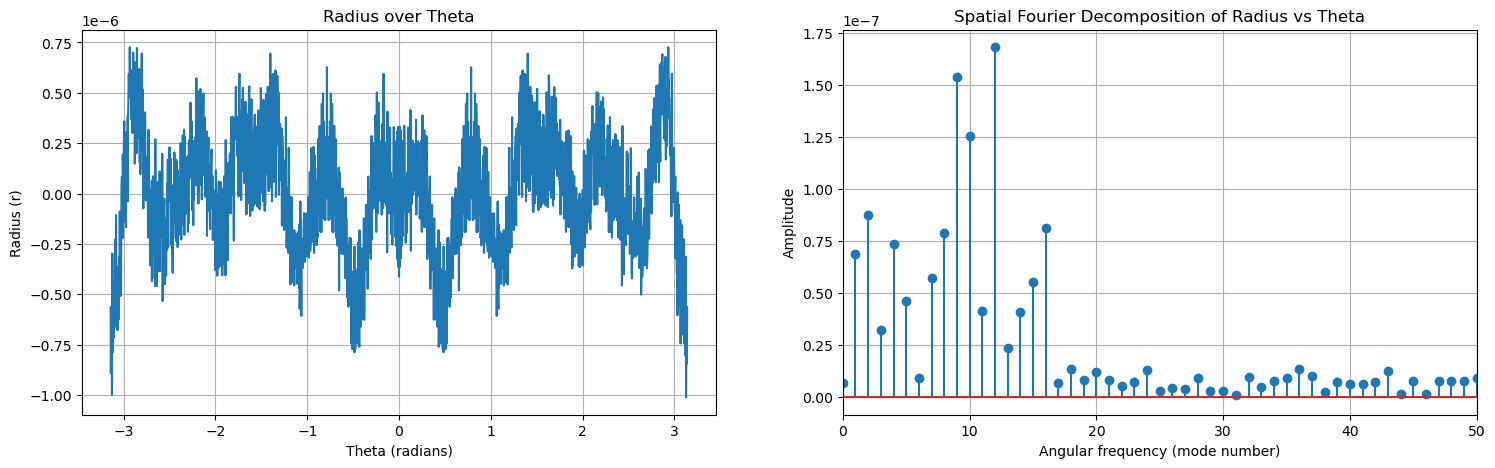

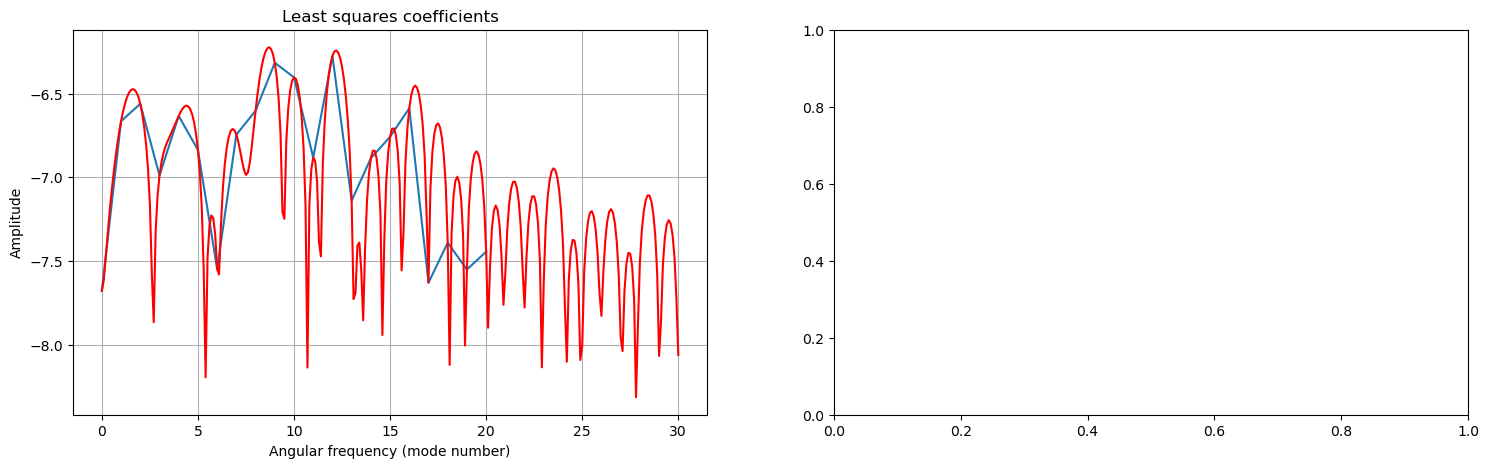

In [4]:
username = os.getlogin()
filepath = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/shapeIC_18.4k_phi_0.6/Uin_02.75_RUN01/database/Isotherm_T_3_amplitude_valid_III.okc")
#df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
df = extract_fields_from_okc(filepath, ['x', 'y'])
theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)
#velocity_mag_unsorted = np.sqrt(df['x_velocity'].to_numpy() ** 2 + df['y_velocity'].to_numpy() ** 2)

# Get the indices that would sort theta and sort the arrays
sorted_indices = np.argsort(theta_unsorted)
theta = theta_unsorted[sorted_indices]
r_fluc = r_fluc_unsorted[sorted_indices]
#velocity_mag = velocity_mag_unsorted[sorted_indices]
#vel_mag_fluc = velocity_mag - np.mean(velocity_mag)
# Calculate the interpolated FFT

r_fluc_omega, r_fluc_amp = interpolated_spline_FFT(theta, r_fluc, os_fact=1, n_modes=-1)

k_plot_lim = 50
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
# Plot r vs. theta
axes[0].plot(theta, r_fluc)
#axes[0].plot(theta, vel_mag_fluc)
axes[0].set_xlabel('Theta (radians)')
axes[0].set_ylabel('Radius (r)')
axes[0].set_title('Radius over Theta')
#axes[1].set_xlim(0, 0.01)
axes[0].grid(True)

# Plot the spectrum
axes[1].stem(r_fluc_omega, r_fluc_amp)
axes[1].set_xlabel('Angular frequency (mode number)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Spatial Fourier Decomposition of Radius vs Theta')
axes[1].grid(True)
axes[1].set_xlim(0, k_plot_lim)
axes[1].set_ylim()
plt.show()
# Calculate the NUFFT
# n_modes = 201
# r_fluc_amp_nu_lr = finufft.nufft1d1(theta, np.asarray(r_fluc, dtype=np.complex128), n_modes, isign=+1)
# pos_ind_lr = len(r_fluc_amp_nu_lr) // 2
# r_fluc_amp_nu_lr = np.abs(r_fluc_amp_nu_lr[pos_ind_lr:])
# k_lr = [i for i in range(0, pos_ind_lr+1)]

modes =  np.linspace(0, 20, 21)
modes_cont =  np.linspace(0, 30, 301)
k_nu, r_fluc_amp_nu = interpolated_NUFFT(theta, r_fluc, modes, 1)
k_nu_cont, r_fluc_amp_nu_cont = interpolated_NUFFT(theta, r_fluc, modes_cont, 1, n_grid=-1)
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes[0].plot(k_nu, np.log10(r_fluc_amp_nu), markersize=1)
axes[0].plot(k_nu_cont, np.log10(r_fluc_amp_nu_cont), markersize=1, color='r')
axes[0].set_xlabel('Angular frequency (mode number)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Least squares coefficients')
#axes[0].set_xlim(0, k_plot_lim)
axes[0].grid(True)

# modes =  np.linspace(0, 5, 11)
# k_ls, r_fluc_amp_ls = least_squares_fit(theta, r_fluc, modes=modes)

# # Plot comparison of NUFFT and interpolated FFT
# fig, axes = plt.subplots(1, 2, figsize=(18, 5))
# axes[0].stem(k_ls, np.log10(r_fluc_amp_ls))
# axes[0].set_xlabel('Angular frequency (mode number)')
# axes[0].set_ylabel('Amplitude')
# axes[0].set_title('Least squares coefficients')
# axes[0].set_xlim(0, k_plot_lim)
# axes[0].grid(True)

# axes[1].stem(k_nu[1:], r_fluc_amp[1:pos_ind_lr+1])# / r_fluc_amp_nu_lr[1:])
# axes[1].set_xlabel('Angular frequency (mode number)')
# axes[1].set_ylabel('Ratio')
# axes[1].set_title('Ratio between interpolated FFT and NUFFT')
# axes[1].set_xlim(0, k_plot_lim)
# axes[1].grid(True)
plt.show()

# plt.plot((np.roll(theta, 1) - theta)[1:] / (2*np.pi/len(theta)), linewidth=0.4)
# plt.show()
# print(r_fluc_amp[:20])
# print(r_fluc_amp_nu_lr[:20])
#dominant_mode = int(r_fluc_omega[np.argmax(r_fluc_amp)])
#print(f"Shape seems to be {dominant_mode}-sided")


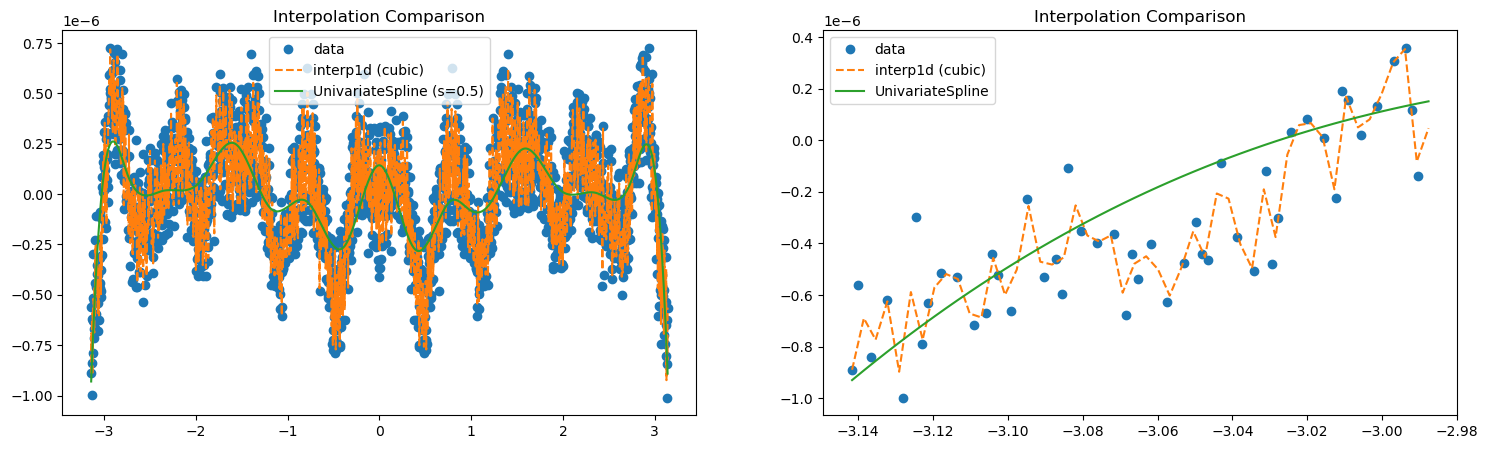

In [5]:
# Noisy data
x = theta
y = r_fluc

x_dense = np.linspace(x[0], x[-1], 2000)

# Exact interpolation (will follow noise)
f_interp = interp1d(x, y, kind='slinear')(x_dense)

# Smooth spline interpolation
f_spline = UnivariateSpline(x, y, s=1e-10)(x_dense)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes[0].plot(x, y, 'o', label='data')
axes[0].plot(x_dense, f_interp, label='interp1d (cubic)', linestyle='--')
axes[0].plot(x_dense, f_spline, label='UnivariateSpline (s=0.5)', linestyle='-')
axes[0].legend()
axes[0].set_title("Interpolation Comparison")

axes[1].plot(x[:50], y[:50], 'o', label='data')
axes[1].plot(x_dense[:50], f_interp[:50], label='interp1d (cubic)', linestyle='--')
axes[1].plot(x_dense[:50], f_spline[:50], label=f'UnivariateSpline', linestyle='-')
axes[1].legend()
axes[1].set_title("Interpolation Comparison")
plt.show()

In [6]:
username = os.getlogin()
case = 'base_18.4k_phi_0.6'
# runs = ["01.30_01", "01.3125_03", "01.375_02", "01.50_02", "01.50_03", "01.75_01", "02.00_02", "02.00_06","02.05_01", "02.10_01", 
#         "02.15_01", "02.20_01", "02.25_02", "02.30_02", "02.35_01", "02.50_02"]
# circle_starts = ["01.50_02", "01.75_01", "02.00_02", "02.25_02", "02.50_02"]
dataset_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dir = dataset_dir / case

cases_df = get_cases(case, 'is_stable')
stable_runs = [f"{u_in}_{int(run):02d}" for u_in, run in zip(cases_df['u_in'], cases_df['run'])]    #  create list from dataframes
circle_df = cases_df[cases_df['circ_cont'] == 'x']
is_cs = (cases_df['circ_cont'] == 'x').to_numpy()

print(stable_runs)
def get_steady_state_properties(run_list, case_dir):
    length_sides = []
    num_sides = []
    inlet_vels = []
    r_means = []
    for run in run_list:
        u_in, run_num = run.split("_")
        run_dir = case_dir / f"Uin_{u_in}_RUN{run_num}"

        # find the Isocontour file with the latest time
        db_files_dir = run_dir / "database"
        all_files = os.listdir(db_files_dir)

        # Filter files that match the pattern and extract time
        matches = []
        for f in all_files:
            match = re.match(r"Isotherm_T_3_t_(\d+)", f)
            if match:
                time_val = int(match.group(1))
                matches.append((f, time_val))

        # Find the file with the largest time
        if matches:
            final_Isocon = max(matches, key=lambda x: x[1])[0]
        else:
            print("[WARNING] No matching files found.")
        filepath = db_files_dir / final_Isocon
        df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
        theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)
        #velocity_mag_unsorted = np.sqrt(df['x_velocity'].to_numpy() ** 2 + df['y_velocity'].to_numpy() ** 2)

        # Get the indices that would sort theta
        sorted_indices = np.argsort(theta_unsorted)
        theta = theta_unsorted[sorted_indices]
        r_fluc = r_fluc_unsorted[sorted_indices]
        
        _num_sides = get_dominant_mode(theta, r_fluc)
        num_sides.append(_num_sides)
        inlet_vels.append(float(u_in)) 
        #df = extract_fields_from_okc(run_dir, ['x', 'y', 'x_velocity', 'y_velocity'])
        filepath = run_dir / "timeseries_T_3_meanvel_len.csv"
        timeseries = pd.read_csv(filepath, sep=r'\s+')
        total_length = float(timeseries['total_length'].iloc[-1])
        length_sides.append(total_length / max(_num_sides, 1))
        r_means.append(r_mean)

    length_sides = np.array(length_sides)
    num_sides = np.array(num_sides)
    inlet_vels =np.array(inlet_vels)
    r_means = np.array(r_means)
    return inlet_vels, num_sides, length_sides, r_means


ss_uin, ss_num_sides, ss_len_sides, ss_r_means = get_steady_state_properties(stable_runs, case_dir)

# Define shared color range
vmin = 4#ss_num_sides.min()
vmax = 9#ss_num_sides.max()
cm = 'Set2'
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

axes[0, 0].scatter(ss_uin[is_cs], 2 * np.pi /ss_len_sides[is_cs], c=ss_num_sides[is_cs], cmap=cm,         vmin=vmin, vmax=vmax, s=100, marker='o', label='Start from circle')
axes[0, 0].scatter(ss_uin[~is_cs], 2 * np.pi / ss_len_sides[~is_cs], c=ss_num_sides[~is_cs], cmap=cm,         vmin=vmin, vmax=vmax, s=50, marker='o', label='Used restart')
#axes[0, 0].scatter(inlet_vels_us, tot_length_us/num_sides_us, c=num_sides_us, cmap='tab10',         vmin=vmin, vmax=vmax, s=100, marker='x', label='Unstable')
axes[0, 0].set_xlabel("Inlet velocity / $S_L$")
axes[0, 0].set_ylabel("Wavenumber")
axes[0, 0].invert_yaxis()
axes[0, 0].set_title("Side length of n-gon coloured by number of sides")
#axes[0, 0].set_ylim(4, 8)
#axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].scatter(ss_uin, ss_num_sides, c=ss_num_sides, cmap=cm, vmin=vmin, vmax=vmax, s=100, marker='o')
axes[0, 1].set_xlabel("Inlet velocity / $S_L$")
axes[0, 1].set_ylabel("Number of sides")
axes[0, 1].set_title("Side length of n-gon coloured by number of sides")
#axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].scatter(ss_uin, ss_num_sides * ss_len_sides, c=ss_num_sides, cmap=cm, vmin=vmin, vmax=vmax, s=100, marker='o')
#axes[1, 0].scatter(inlet_vels_us, tot_length_us, c=num_sides_us, cmap='tab10', s=100, marker='x')
axes[1, 0].set_xlabel("Inlet velocity / $S_L$")
axes[1, 0].set_ylabel("Total length / $d_f$")
axes[1, 0].set_title("Total length of isocontour coloured by number of sides")
#plt.legend()
axes[1, 0].grid(True)
res = linregress(ss_uin, ss_num_sides * ss_len_sides)
x_fit = np.linspace(1.25, 3.0, 100)
y_fit = res.slope * x_fit + res.intercept
y_pred = 3 * x_fit
axes[1, 0].plot(x_fit, y_fit, color='black', label='Fit', linestyle='--')
print(res.slope, res.intercept)

axes[1, 1].scatter(ss_uin, ss_r_means, c=ss_num_sides, cmap=cm, vmin=vmin, vmax=vmax, s=100, marker='o')
axes[1, 1].set_xlabel("Inlet velocity / $S_L$")
axes[1, 1].set_ylabel("Mean radius / $d_f$")
axes[1, 1].set_title("Mean radius of n-gon coloured by number of sides")
#axes[1, 1].legend()
axes[1, 1].grid(True)
res = linregress(ss_uin, ss_r_means)
x_fit = np.linspace(1.00, 3.0, 100)
y_fit = res.slope * x_fit + res.intercept
y_pred = 3 * x_fit
axes[1, 1].plot(x_fit, y_fit, color='black', label='Fit', linestyle='--')
print(res.slope, res.intercept)

plt.show()


def predict_shape(u_in, slope, intercept):
    l_tot_pred = u_in * slope + intercept
    num_sides = []
    l_sides = []
    for num_side in range(4,10):
        l_side = l_tot_pred / num_side
        if l_side > 5.8 and l_side < 6.8:
            num_sides.append(num_side)
            l_sides.append(l_side)
    print(num_sides)
    print(l_sides)


['01.00_01', '01.25_03', '01.50_04', '01.75_01', '01.75_08', '02.00_02', '02.00_05', '02.00_06', '02.05_01', '02.10_01', '02.15_01', '02.20_01', '02.25_02', '02.25_04', '02.30_02', '02.35_01', '02.50_02', '02.75_08']


OSError: [WinError 1920] Das System kann auf die Datei nicht zugreifen: 'C:\\Users\\Florian\\OneDrive - ETH Zurich\\Semester 10\\Master Thesis\\Sim results\\base_18.4k_phi_0.6\\Uin_01.00_RUN01\\database'

In [8]:
def extract_fourier_modes(run_list, case_dir, num_modes = 50, nu_res = 1, method='both'):
    """
    Input:
        run_list:       list: runs with format <u_in>_<run_number>
        case_dir:       str: directory to the casefiles e.g .../sim_results/base_18.4k_phi_0.6
        num_modes:      int: number of first modes to output (exluding the 0 mode)
        nu_res:         int: resolution factor for non-uniform sampling (broken with least squares)
        method:         str: method of calculating the modes; fft - use fast fourier transform; ls - use least squares; both - use both

    Output:
        scalars_arr     array(timesteps x 4): Array of scalars at each timestep; col 1 - time, col 2 - mean velocity magnitude; col 3 - length of isotherm; col 4 - mean radius
        amp_tot         array(timesteps x num_modes): Array of the amplitude of fourier coeffs for the modes - from FFT
        k_tot           array(timesteps x num_modes): Array of the wavenumber of the modes - from FFT
        amp_ni_tot      array(timesteps x num_modes): Array of the amplitude of fourier coeffs for the modes - from least squares
        k_ni_tot        array(timesteps x num_modes): Array of the wavenumber of the modes - from least squares

    """
    scalars_arr_list =  []
    amp_arr_list =      []
    k_arr_list =        []
    amp_ni_arr_list =   []
    k_ni_arr_list =     []
    for run in run_list:   
        # Set directories of run
        u_in, run_num = run.split("_")
        run_dir = case_dir / f"Uin_{u_in}_RUN{run_num}"
        db_files_dir = run_dir / "database"

        # Extract the timesteps and scalar values from the csv file
        filepath = run_dir / "timeseries_T_3_meanvel_len.csv"
        timeseries = pd.read_csv(filepath, skipinitialspace=True)
        num_files = len(timeseries)
        # initialize data arrays
        scalars_arr = np.empty((num_files, 4))
        scalars_arr[:,0] = timeseries['time'].to_numpy()
        scalars_arr[:,1] = timeseries['v_mag_mean'].to_numpy()
        scalars_arr[:,2] = timeseries['total_length'].to_numpy()

        amp_arr     = np.empty((num_files, num_modes))
        k_arr       = np.empty((num_files, num_modes))
        amp_ni_arr  = np.empty((num_files, num_modes * nu_res))
        k_ni_arr    = np.empty((num_files, num_modes * nu_res))

        db_files = [f"Isotherm_T_3_t_{time:.2f}.okc" for time in scalars_arr[:,0]]

        if method == 'both' or method == 'fft':
            for i, file in enumerate(db_files):
                filepath = db_files_dir / file
                # Read the file
                df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
                theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)
                scalars_arr[i,3] = r_mean
                
                # Sort arrays by theta
                sorted_indices = np.argsort(theta_unsorted)
                theta = theta_unsorted[sorted_indices]
                r_fluc = r_fluc_unsorted[sorted_indices]
                
                # Perform spatial FFT on the real length data
                r_fluc_k_r, r_fluc_amp_r = interpolated_spline_FFT(theta * r_mean, r_fluc, n_modes=num_modes+1)
                amp_arr[i] = r_fluc_amp_r[1:num_modes+1]
                k_arr[i,:] = r_fluc_k_r[1:num_modes+1]

            #k_fixed = k_arr[10]

        if method == 'both' or method == 'ls':
            for i, file in enumerate(db_files):
                filepath = db_files_dir / file
                # Read the file
                df = extract_fields_from_okc(filepath, ['x', 'y'])
                theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)
                if method != 'both': scalars_arr[i,3] = r_mean

                # Sort arrays by theta
                sorted_indices = np.argsort(theta_unsorted)
                theta = theta_unsorted[sorted_indices]
                r_fluc = r_fluc_unsorted[sorted_indices]
                # Use finufft type-1 (nonuniform to uniform)
                # nu_fixed_norm = k_fixed * r_mean
                modes_non_fixed = np.linspace(1 / nu_res, num_modes, nu_res * num_modes)
                #k_smooth, amp_smooth = interpolated_NUFFT(theta, r_fluc, modes_non_fixed, r_mean)
                k_smooth, amp_smooth = least_squares_fit(theta, r_fluc, modes=modes_non_fixed, r_mean=r_mean)
                amp_ni_arr[i] = np.abs(amp_smooth)
                k_ni_arr[i] = k_smooth

        # Create list from all run arrays
        scalars_arr_list.append(scalars_arr)
        amp_arr_list.append(amp_arr)
        k_arr_list.append(k_arr)
        amp_ni_arr_list.append(amp_ni_arr)
        k_ni_arr_list.append(k_ni_arr)

    # Concatenate arrays into one
    scalars_tot = np.concatenate(scalars_arr_list)
    amp_tot = np.concatenate(amp_arr_list)
    k_tot = np.concatenate(k_arr_list)
    amp_ni_tot = np.concatenate(amp_ni_arr_list)
    k_ni_tot = np.concatenate(k_ni_arr_list)
    return scalars_tot, amp_tot, k_tot, amp_ni_tot, k_ni_tot

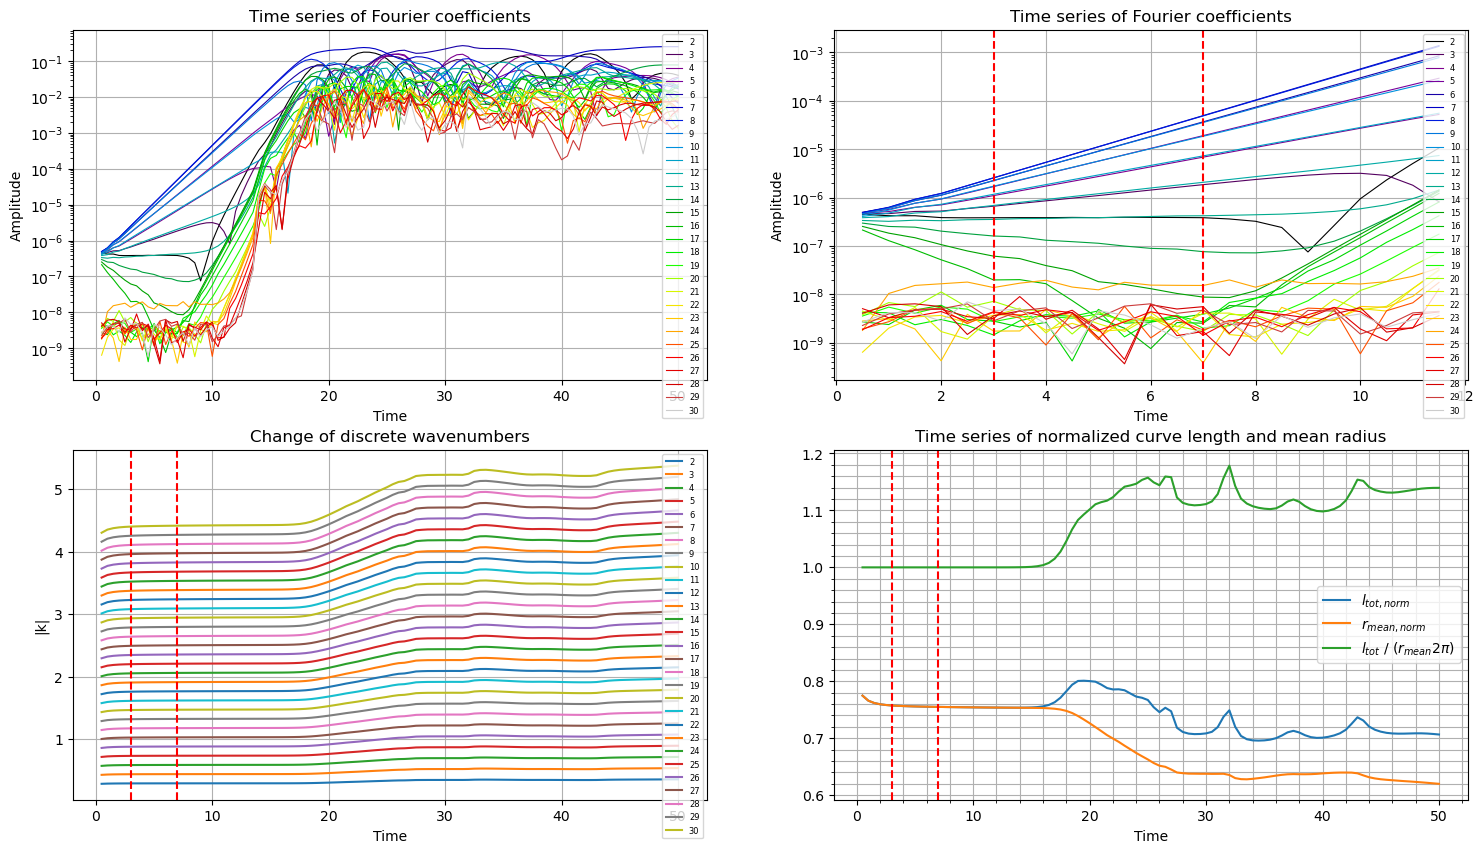

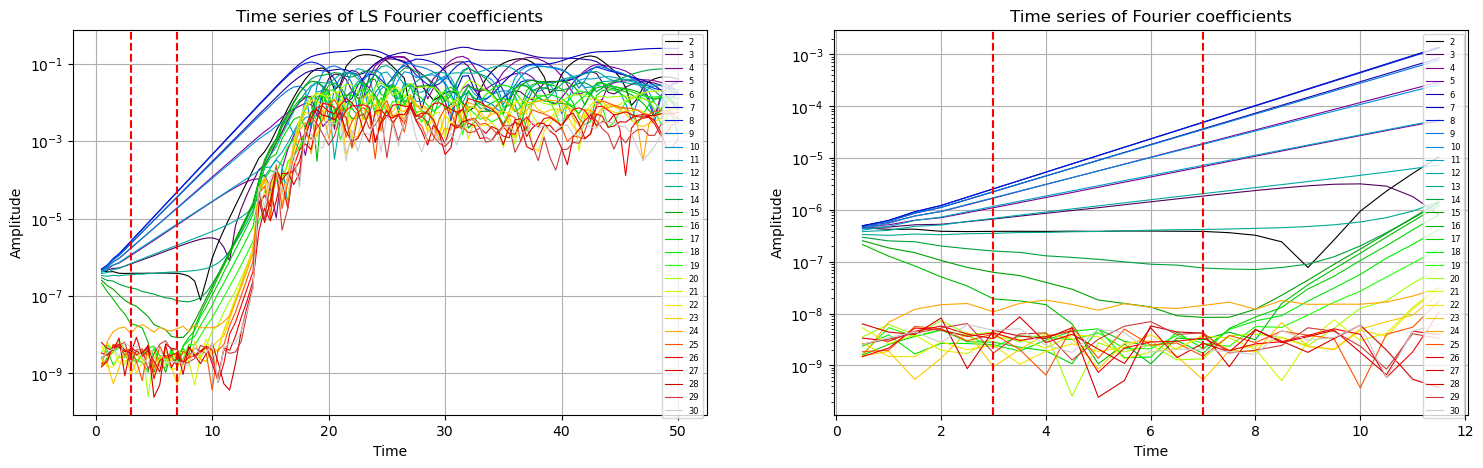

In [52]:
username = os.getlogin()
#case1 = "base_18.4k_phi_0.6"
#case1 = "large_23.6k_phi_0.6"
#case1 = "base_18.4k_phi_0.75"
#case1 = "le1_18.4k_phi_0.75"
#case1 = "5atmlarge_42k_phi_0.6"
case1 = "shapeIC_18.4k_phi_0.6"
#runs = ["01.00_01"]
#runs = ["01.3125_01", "01.3125_02", "01.3125_03"]
#runs = ["01.50_04"]
#runs = ["01.75_08"]
#runs = ["02.00_06"]
runs = ["02.25_01"]
#runs = ["02.50_01"]
#runs = ["02.75_02"]
#runs = ["02.00_01"]
#runs = ["03.00_01"]
#runs = ["10.00_03"]
#runs = ["01.75_03", "01.75_04", "01.75_05", "01.75_06"]
dataset_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dir = dataset_dir / case1
scalars_tot, amp_tot, k_tot, amp_ni_tot, k_ni_tot = extract_fourier_modes(runs, case_dir, num_modes=100, nu_res=1)
# Extract dispersion relation
plt_s = slice(1, 30)
#modes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ,13] 
modes = list(range(2, 20))
t_start = 3
t_end = 7
t_start_ind = np.argmin(np.abs(scalars_tot[:,0] - t_start))
t_end_ind = np.argmin(np.abs(scalars_tot[:,0] - t_end))

my_cmap = plt.get_cmap('nipy_spectral')
colors = my_cmap(np.linspace(0, 1, (plt_s.stop - plt_s.start)))


# Plot whole time series of fourier coefficients
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
for i in range(plt_s.start, plt_s.stop):
    axes[0, 0].semilogy(scalars_tot[:,0], amp_tot[:,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_title('Time series of Fourier coefficients')
axes[0, 0].grid(True)
axes[0, 0].legend(prop={'size': 6})

# Plot narrowed range to show linear growth better
for i in range(plt_s.start, plt_s.stop):
    axes[0, 1].semilogy(scalars_tot[max(0, int(t_start_ind)-20):t_end_ind+10,0], amp_tot[max(0, int(t_start_ind)-20):t_end_ind+10,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[0, 1].axvline(x=t_start, color='red', linestyle='--')
axes[0, 1].axvline(x=t_end, color='red', linestyle='--')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title('Time series of Fourier coefficients')
axes[0, 1].grid(True)
axes[0, 1].legend(prop={'size': 6})

# Plot change of noninteger wavenumber
#axes[1, 0].plot(scalars_tot[:,0], k_ni_tot[:,plt_s.start:plt_s.stop])
axes[1, 0].plot(scalars_tot[:,0], k_tot[:,plt_s.start:plt_s.stop])
axes[1, 0].axvline(x=t_start, color='red', linestyle='--')
axes[1, 0].axvline(x=t_end, color='red', linestyle='--')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('|k|')
axes[1, 0].set_title('Change of discrete wavenumbers')
axes[1, 0].grid(True)
axes[1, 0].legend([str(i+1) for i in range(plt_s.start, plt_s.stop)], prop={'size': 6})

# Plot total length (inverse prop. to |k|)
#r_init = scalars_tot[0,3]
r_init = 9
l_init = r_init * 2 * np.pi
axes[1, 1].plot(scalars_tot[:,0], scalars_tot[:,2] / l_init, label='$l_{tot,norm}$')
axes[1, 1].plot(scalars_tot[:,0], scalars_tot[:,3] / r_init, label='$r_{mean,norm}$')
axes[1, 1].plot(scalars_tot[:,0], scalars_tot[:,2] / (scalars_tot[:,3] * 2 * np.pi), label=r'$l_{tot}$ / ($r_{mean} 2 \pi$)')
axes[1, 1].axvline(x=t_start, color='red', linestyle='--')
axes[1, 1].axvline(x=t_end, color='red', linestyle='--')
axes[1, 1].set_title('Time series of normalized curve length and mean radius')
axes[1, 1].set_xlabel('Time')
axes[1, 1].minorticks_on()
axes[1, 1].grid(True, which='both')
axes[1, 1].legend(prop={'size': 10})
plt.show()

# fig, axes = plt.subplots(1, 2, figsize=(18, 5))
# axes[0].plot(time_tot, num_samples, linewidth=0.8)
# axes[0].set_xlabel('Time')
# axes[0].set_ylabel('#')
# axes[0].set_title('number of samples')
# axes[0].grid(True)
# axes[0].legend(prop={'size': 6})
# print(k_r_tot[10, 1:20])

# plt.show()

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
for i in range(plt_s.start, plt_s.stop):
    axes[0].semilogy(scalars_tot[:,0], np.abs(amp_ni_tot[:,i]), color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[0].axvline(x=t_start, color='red', linestyle='--')
axes[0].axvline(x=t_end, color='red', linestyle='--')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Time series of LS Fourier coefficients')
axes[0].grid(True)
axes[0].legend(prop={'size': 6})

for i in range(plt_s.start, plt_s.stop):
    axes[1].semilogy(scalars_tot[max(0, int(t_start_ind)-20):t_end_ind+10,0], amp_ni_tot[max(0, int(t_start_ind)-20):t_end_ind+10,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[1].axvline(x=t_start, color='red', linestyle='--')
axes[1].axvline(x=t_end, color='red', linestyle='--')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Time series of Fourier coefficients')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
plt.show()

# num_t = len(scalars_tot[:,0])
# k_ni_max = np.empty(num_t)
# for i in range(len(scalars_tot[:,0])):
#     k_ni_max[i] = k_ni_tot[i,np.argmax(amp_ni_tot[i])]
# plt.scatter(scalars_tot[:,0], k_ni_max)
# plt.show()


Mean radius:  6.805841599385716
2	0.004	0.294	0.0031
3	0.256	0.441	0.0031
4	0.457	0.588	0.0031
5	0.605	0.734	0.0031
6	0.699	0.881	0.0031
7	0.740	1.028	0.0031
8	0.736	1.175	0.0031
9	0.690	1.322	0.0031
10	0.594	1.469	0.0031
11	0.457	1.616	0.0031
12	0.275	1.763	0.0031
13	0.045	1.910	0.0031
14	-0.190	2.057	0.0031
15	-0.543	2.203	0.0031
16	-0.899	2.350	0.0031
17	0.107	2.497	0.0031
18	0.076	2.644	0.0031
19	0.022	2.791	0.0031


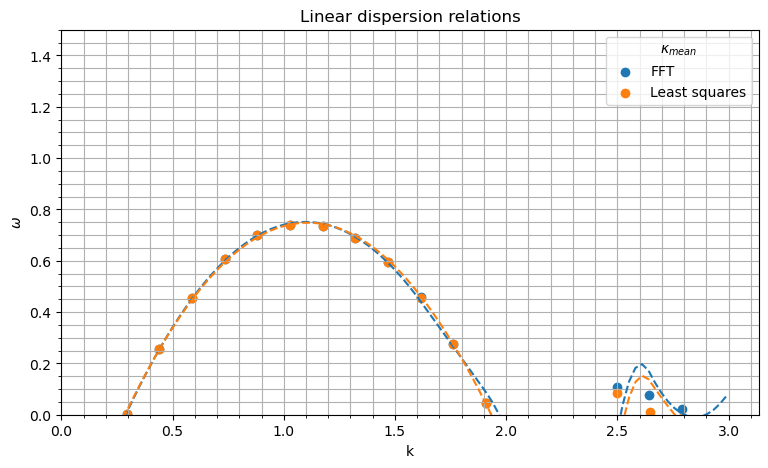

In [53]:
def get_growth_exp(t, k, amp, time_slice, modes, output='terminal'):
    """ Function to calculate exponential growth exponent omega in amp(t) ~ C * exp(omega * t)
    Input
        t:      array of timesteps where k and amp where calculated
        k:      array of wavenumbers with dimension (len(t), >max(modes))
        amp:    array of fourier coeff. amplitude, same dimension as k
        modes:  list of mode number where growth exponent should be evaluated
        output: mode of output for individual values (terminal -> print output)
    Output
        slopes_arr: array of omegas with len(modes)
        k_mean_arr: array of mean wavenumber over time with len(modes)
    """
    # Get indices from times and slice the input arrays
    t_start_ind = np.argmin(np.abs(t - time_slice[0]))
    t_end_ind = np.argmin(np.abs(t - time_slice[1]))
    sliced_amp = amp[t_start_ind:t_end_ind]
    sliced_k = k[t_start_ind:t_end_ind]
    sliced_t = t[t_start_ind:t_end_ind]

    # Get the logarithm of the amplitude and prepare output arrays
    log_amp = np.log(sliced_amp)
    slopes_arr = np.empty((len(modes)))
    k_mean_arr = np.empty((len(modes)))

    # Loop over all timesteps to get growthrate and mean wavenumber
    for i, mode in enumerate(modes):
        slope, intercept, r_value, p_value, std_err = linregress(sliced_t, log_amp[:, mode-1])
        k_mean = np.mean(sliced_k[:, mode-1])
        k_rel_change = (sliced_k[-1, mode-1] - sliced_k[0, mode-1]) / sliced_k[0, mode-1]
        if output == 'terminal':
            print(f"{mode}\t{slope:.3f}\t{k_mean:.3f}\t{abs(k_rel_change):.4f}")
        slopes_arr[i] = slope # type: ignore
        k_mean_arr[i] = k_mean
    return slopes_arr, k_mean_arr

def plot_growth_exp(omega_list, k_list, labels, title="Linear dispersion relations"):
    """ Function to plot the growth exponents over the wavenumber to get the linear dispersion curve
    Input:
        omega_list:     list of arrays containing the growth exponents (array from get_growth_exponent(...))
        k_list:         list of arrays containing the mean wavenumbers
        labels:         list of lables for each run
        title:          str: title of plot
        The each entry in the lists should contain the results from one run, len(lists) = no. of runs, 
        The arrays omega and k must have the same length per run
    """
    # Check if there is a omega and k for each run
    if len(omega_list) != len(k_list):
        raise ValueError("shapes of omega and k does not match")

    # Initialize plot
    plt.figure(figsize=(9, 5))
    # Iterate though all runs
    i = 0
    for omega, k in zip(omega_list, k_list):
        # create spline to show interpolated
        k_spline = np.linspace(k[0], k[-1], len(omega)*5)
        k_Bspline = np.linspace(k[0] - 0.2, k[-1] + 0.2, 100) 
        spline = interp1d(k, omega, kind='cubic')
        Bspline = UnivariateSpline(k, omega, k=2, s=0.1, ext=0)
        omega_interp = spline(k_spline)
        omega_Bspline = Bspline(k_Bspline)

        # plot actual values and spline
        plt.scatter(k, omega, label=labels[i])
        #plt.plot(k_spline, omega_interp)
        plt.plot(k_Bspline, omega_Bspline, linestyle='--')
        i += 1

    # Format the plot
    plt.xlabel('k')
    plt.ylabel(r'$\omega$')
    plt.title(title)
    plt.xlim(left = 0)
    plt.ylim(bottom = -0.0, top = 1.5)
    plt.legend(title=r'$\kappa_{mean}$')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.show()
    return

def get_mean_curvature(t, r, time_slice):
    t_start_ind = np.argmin(np.abs(t - time_slice[0]))
    t_end_ind = np.argmin(np.abs(t - time_slice[1]))
    sliced_r = r[t_start_ind:t_end_ind]
    r_mean = np.mean(sliced_r)
    return 1 / r_mean

print("Mean radius: ", np.mean(scalars_tot[t_start_ind:t_end_ind,3]))
#fig = plt.figure()

omega_disp, k_disp = get_growth_exp(scalars_tot[:,0], k_tot, amp_tot, [t_start, t_end], modes)
omega_disp_ls, k_disp_ls = get_growth_exp(scalars_tot[:,0], k_ni_tot, amp_ni_tot, [t_start, t_end], modes, output='None')
plot_growth_exp([omega_disp, omega_disp_ls], [k_disp, k_disp_ls], ['FFT', 'Least squares'])

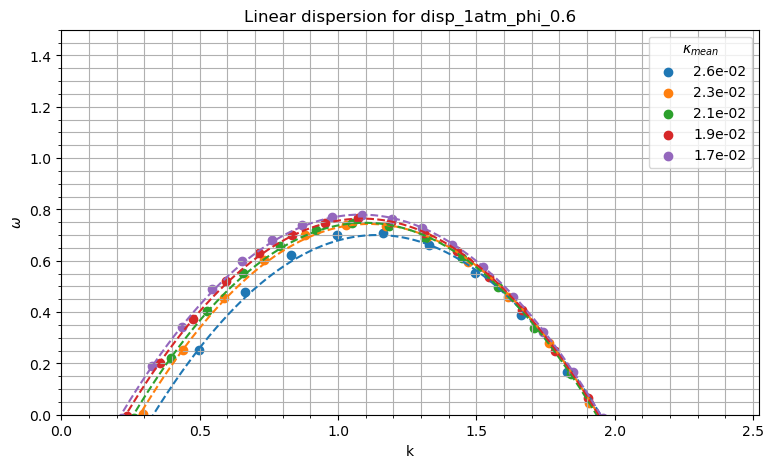

In [48]:
username = os.getlogin()
filepath = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
runs_csv_dir = filepath / "caselist_post_proc.csv"
runs_df = pd.read_csv(runs_csv_dir, dtype=str)
# filter runs for the ones needed here
run_disp = runs_df[runs_df['run_disp'] == 'x']
disp_phi06 = run_disp[run_disp['case'] == 'disp_1atm_phi_0.6']
base_phi075 = run_disp[run_disp['case'] == 'base_18.4k_phi_0.75']
le1_phi075 = get_cases('base_18.4k_phi_0.6', 'run_disp')   #run_disp[run_disp['case'] == 'le1_18.4k_phi_0.75']

def plot_case_dispersion(case_df, filepath):
    #print(case_df)
    omega_disp_list = [np.empty] * len(case_df)
    k_disp_list = [np.empty] * len(case_df)
    labels = []
    for i, row in enumerate(case_df.itertuples(index=False)):
        # convert from row
        case = row.case
        u_in = row.u_in
        run = row.run
        mode_start, mode_stop = map(int, str(row.disp_modes).split("_"))
        modes = list(range(mode_start, mode_stop + 1))
        t_start, t_stop = map(float, row.disp_times.split("_"))
        runs = [f"{u_in}_{int(run):02d}"]
        case_dir = filepath / case
        #print(case_dir, runs)
        scalars_tot, _amp_tot, _k_tot, amp_ls_tot, k_ls_tot = extract_fourier_modes(runs, case_dir, num_modes=mode_stop + 1, method='ls')
        omega_disp_list[i], k_disp_list[i] = get_growth_exp(scalars_tot[:,0], k_ls_tot, amp_ls_tot, [t_start, t_stop], modes, output='none')
        # calculate mean curvature
        kappa = get_mean_curvature(scalars_tot[:,0], scalars_tot[:,2], [t_start, t_stop])
        labels.append(f"{kappa:.1e}")
    plot_growth_exp(omega_disp_list, k_disp_list, labels, title=f"Linear dispersion for {case_df['case'].iloc[0]}")
    

plot_case_dispersion(disp_phi06, filepath)

In [ ]:
username = os.getlogin()
case1 = "base_18.4k_phi_0.6"
#case1 = "large_23.6k_phi_0.6"
#case1 = "base_18.4k_phi_0.75"
#case1 = "le1_18.4k_phi_0.75"
runs = ["01.75_02", "01.75_03", "01.75_04", "01.75_05", "01.75_06", "01.75_07"]
dataset_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dir = dataset_dir / case1
plt_s = slice(1, 15)

lengths_tot, time_tot, amp_tot, k_r_tot, r_mean_tot = extract_fourier_modes(runs, case_dir)

my_cmap = plt.get_cmap('nipy_spectral')
colors = my_cmap(np.linspace(0, 1, (plt_s.stop - plt_s.start)))

# Plot whole time series of fourier coefficients
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
for i in range(plt_s.start, plt_s.stop):
    axes[0].semilogy(time_tot, amp_tot[:,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Time series of Fourier coefficients')
axes[0].grid(True)
axes[0].legend(prop={'size': 6})

for i in range(plt_s.start, plt_s.stop):
    axes[1].plot(time_tot, amp_tot[:,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Time series of Fourier coefficients')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})

plt.figure(figsize=(9, 6))
plt.plot(time_tot, lengths_tot/np.mean(lengths_tot))
plt.plot(time_tot, r_mean_tot/np.mean(r_mean_tot))
plt.title('Time series of normalized curve length and mean radius')
plt.xlabel('Time')
plt.show()

In [ ]:
import os
import ipywidgets as widgets
from IPython.display import display

# Assuming your simulation cases are in a directory, e.g., './cases'
case_base_dir =  Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dirs = [d for d in os.listdir(case_base_dir) if os.path.isdir(os.path.join(case_base_dir, d))]

case_selector = widgets.Dropdown(
    options=case_dirs,
    description='Case:',
    disabled=False,
)

display(case_selector)
print(case_selector)


In [ ]:
selected_case = case_selector.value
selected_case_path = os.path.join(case_base_dir, selected_case)
print(selected_case_path)